In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

In [8]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_distance(point1, point2):
    """
    두 점 간의 유클리드 거리를 계산하는 함수입니다.

    :param point1: 첫 번째 점의 좌표 (x1, y1)
    :param point2: 두 번째 점의 좌표 (x2, y2)
    :return: 두 점 간의 거리
    """
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
def plot_ransac_revised(segment_data_x, segment_data_y):
    from skimage.measure import LineModelND, ransac
    data = np.column_stack([segment_data_x, segment_data_y])

    # fit line using all data
    model = LineModelND()
    model.estimate(data)

    # robustly fit line only using inlier data with RANSAC algorithm
    model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                                   residual_threshold=5, max_trials=1000)
    outliers = inliers == False

    # generate coordinates of estimated models
    line_x = np.array([segment_data_x.min(), segment_data_x.max()])
    line_y = model.predict_y(line_x)
    line_y_robust = model_robust.predict_y(line_x)
    k = (line_y_robust[1] - line_y_robust[0]) / (line_x[1] - line_x[0])
    m = line_y_robust[0] - k * line_x[0]
    x0 = (segment_data_y.min() - m) / k
    x1 = (segment_data_y.max() - m) / k
    line_x_y = np.array([x0, x1])
    line_y_robust_y = model_robust.predict_y(line_x_y)
    if (distance(line_x[0], line_y_robust[0], line_x[1], line_y_robust[1]) <
            distance(line_x_y[0], line_y_robust_y[0], line_x_y[1], line_y_robust_y[1])):
                # plt.plot(line_x, line_y_robust, '-b', label='Robust line model')
        line_twopoint = (line_x, line_y_robust)
    else:
                # plt.plot(line_x_y, line_y_robust_y, '-b', label='Robust line model')
        line_twopoint = (line_x_y, line_y_robust_y)

    return inliers, outliers, line_twopoint


def line_intersection(line1, line2, x_min, x_max, y_min, y_max):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div

    # 범위 내의 값인지 체크
    if x_min - 100 <= x <= x_max + 100 and y_min - 100 <= y <= y_max + 100:
        return x, y
    else:
        return -12345, -12345

def coord_sort_n(x):
    x = np.array(x)
    k = x[:,0]
    s = k.argsort()
    centers_sorted = x[s]
    for i in range(len(centers_sorted)//2):
        b = centers_sorted[2*i:2*(i+1),:]
        k = b[:,1]
        s = k.argsort()
        centers_sorted[2*i:2*(i+1), :] = b[s]
    return centers_sorted

def homography(img, points, width, height):
    pts1 = np.float32(coord_sort_n(points))
    pts2 = np.float32([[0, 0], [0,height], [width, 0], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # img = img_to_coord(img)
    img = cv2.warpPerspective(img, matrix, (width, height))
    return img

def cluster(point_data, n_cluster=8):
    '''
    <input>
    point_data: 중심점을 구할 포인트 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )
    n_cluster: 클러스터링할 그룹의 수

    <output>
    centers: 중심점 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )
    '''
    model = KMeans(n_clusters=n_cluster)
    model.fit(point_data)
    predict = model.predict(point_data)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(predict))))
    k_means_labels = model.labels_
    k_means_cluster_centers = model.cluster_centers_
    for k, col in zip(range(n_cluster), colors):
        my_members = (k_means_labels == k)

        # 중심 정의
        cluster_center = k_means_cluster_centers[k]

    centers = np.array(k_means_cluster_centers, dtype=int)
    return centers


def draw_dab_distances(centers):
    '''
    <input>
    centers: 중심점을 구할 포인트 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )

    <output>
    없음
    '''
    centers_x = centers[:,0]  # x 좌표 집합
    centers_y = centers[:,1]  # y 좌표 집합
    distances_vert = []
    distances_horiz = []
    alpha = 1 # 보정계수, projectvie transformation에 적용했던 실제 사이즈 축적의 역수. 1:1 -> 1, 절반크기로 했으면 2, 2배 크기로 했으면 1/2
    for k in range(0, len(centers) ,2):
        distances_vert.append(round(Point(centers[k]).distance(Point(centers[k+1]))*alpha, 2))
        plt.plot((centers_x[k], centers_x[k+1]),(centers_y[k],centers_y[k+1]), marker="o",linestyle=":") # 선 그리기
        plt.text((centers_x[k] + centers_x[k+1])/2 ,(centers_y[k]+centers_y[k+1])/2, distances_vert[-1], color="white") # 거리값 쓰기
    for k in range(0, int(len(centers)/2)+1):
        distances_horiz.append(round(Point(centers[k]).distance(Point(centers[k+2]))*alpha, 2))
        plt.plot((centers_x[k], centers_x[k+2]),(centers_y[k],centers_y[k+2]), marker="s",linestyle="--")
        plt.text((centers_x[k]+centers_x[k+2])/2 ,(centers_y[k]+centers_y[k+2])/2, distances_horiz[-1],color="white")
def ribbon_gap(ribbon_homo, axis):
    if axis == "0":
        y_diff = []
        y_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[:, int(ribbon_homo.shape[1]/2):]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    elif axis == "1":
        y_diff = []
        y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[int(ribbon_homo.shape[0]/2):, :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    y_diff = np.array(y_diff)
    # print(y_diff)
    # print(np.min(y_diff))
    
    return y_diff
def plot_points_with_labels(points):
    for i, point in enumerate(points):
        plt.text(point[0], point[1], str(i), color='black')


def draw_dab_distances(centers):
    centers = coord_sort_z(centers)
    centers_x = centers[:,0]
    centers_y = centers[:,1]
    distances_vert = []
    distances_horiz = []
    a = 1
    for k in range(0, 8, 2):  # 수정된 범위 (0부터 8까지, 간격은 2)
        dist_vert = calculate_distance(centers[k], centers[k+1])
        distances_vert.append(round(dist_vert * a, 2))
        plt.plot((centers_x[k], centers_x[k+1]), (centers_y[k], centers_y[k+1]), marker="o", linestyle=":")
        plt.text((centers_x[k]+centers_x[k+1])/2 ,(centers_y[k]+centers_y[k+1])/2, distances_vert[-1], color="white")
    
    for k in range(0, 6):  # 수정된 범위 (0부터 6까지)
        dist_horiz = calculate_distance(centers[k], centers[k+2])
        distances_horiz.append(round(dist_horiz * a, 2))
        plt.plot((centers_x[k], centers_x[k+2]), (centers_y[k], centers_y[k+2]), marker="s", linestyle="--")
        plt.text((centers_x[k]+centers_x[k+2])/2 ,(centers_y[k]+centers_y[k+2])/2, distances_horiz[-1], color="white")
def coord_sort_z(x):
    # Convert input to a NumPy array
    x = np.array(x)
    
    # Sort by y-coordinate
    k = x[:, 1]  # Selecting the second column (y-coordinate)
    s = k.argsort()
    centers_sorted = x[s]
    
    # Within each pair, sort by x-coordinate
    for i in range(len(centers_sorted)//2):
        b = centers_sorted[2*i:2*(i+1), :]
        k = b[:, 0]  # Selecting the first column (x-coordinate)
        s = k.argsort()
        centers_sorted[2*i:2*(i+1), :] = b[s]
    
    return centers_sorted


In [3]:
xy = np.load('../ribbon_point.npy')
img_dir = "../IMG_4245_JPG.rf.63460a44ffb7591e4ab7aaa7483d11e6.jpg"
img = cv2.imread(img_dir)

In [10]:
x_data = xy[:, 0]
y_data = xy[:, 1]
x_tmp = x_data.copy()
y_tmp = y_data.copy()
ransac_line = []
intersection_points = []
while True:
    inliers, outliers, line_twopoint = plot_ransac_revised(x_tmp, y_tmp)

    if x_tmp[inliers].shape[0] >= 2:
        # inliers, two points for line 기록 저장
        ransac_line.append((x_tmp[inliers], y_tmp[inliers], line_twopoint))

    # 나머지 점들 (outliers)
    x_tmp = x_tmp[outliers]
    y_tmp = y_tmp[outliers]

    # if x_tmp.shape[0] <= 2 or len(ransac_line) == 4:
    if len(ransac_line) == 4:
        break
x_min, x_max, y_min, y_max = x_data.min(), x_data.max(), y_data.min(), y_data.max()
for i in range(len(ransac_line)):
    for j in range(i + 1, len(ransac_line)):
        (x1, x2), (y1, y2) = ransac_line[i][2]
        (x3, x4), (y3, y4) = ransac_line[j][2]
        x, y = line_intersection([[x1, y1], [x2, y2]], [[x3, y3], [x4, y4]], x_min, x_max, y_min, y_max)
        if x != -12345 or y != -12345:
            intersection_points.append(np.array((x, y)))


intersection_points

[array([110.02323, 462.9714 ], dtype=float32),
 array([242.78189, 151.68405], dtype=float32),
 array([438.00345, 493.46152], dtype=float32),
 array([441.69702, 164.74635], dtype=float32)]

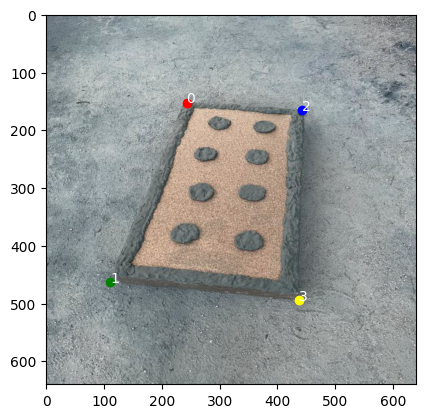

In [5]:
# intersection_points = coord_sort_n(intersection_points)
plt.scatter(intersection_points[0,0], intersection_points[0,1], color = 'red')
plt.text(intersection_points[0,0], intersection_points[0,1], "0", color = 'white')
plt.scatter(intersection_points[1,0], intersection_points[1,1], color = 'green')
plt.text(intersection_points[1,0], intersection_points[1,1], "1", color = 'white')
plt.scatter(intersection_points[2,0], intersection_points[2,1], color = 'blue')
plt.text(intersection_points[2,0], intersection_points[2,1], "2", color = 'white')
plt.scatter(intersection_points[3,0], intersection_points[3,1], color = 'yellow')
plt.text(intersection_points[3,0], intersection_points[3,1], "3", color = 'white')
plt.imshow(img)

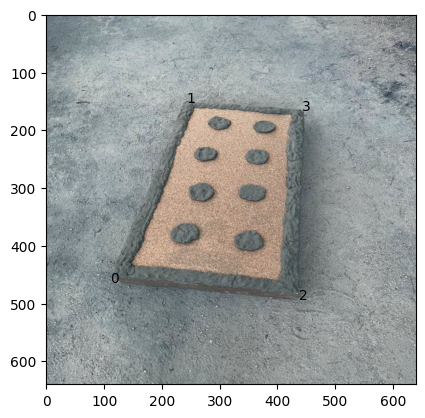

In [11]:
plot_points_with_labels(intersection_points)
plt.imshow(img)
plt.show()

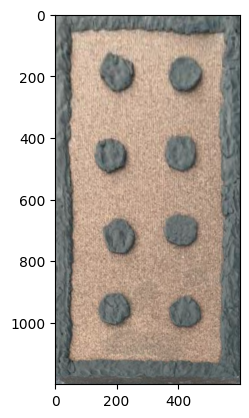

In [12]:
img_homo = homography(img, intersection_points, width=600, height=1200)
plt.imshow(img_homo)

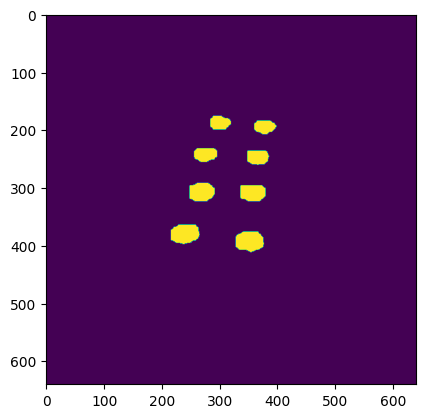

In [13]:
# 로드할 파일들의 개수
num_files = 8

# 로드한 데이터를 저장할 리스트
segmented_data = []

# 파일을 로드하는 루프
for i in range(num_files):
    filename = f'../segmented{i}.npy'
    data = np.load(filename)
    segmented_data.append(data)

combined_data = np.sum(segmented_data, axis=0)

# segmented_data에는 이제 각각의 segmented 데이터가 저장됨
plt.imshow(combined_data)


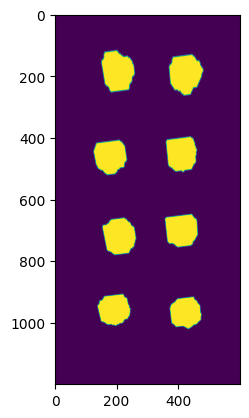

In [14]:
dab_homo = homography(combined_data, intersection_points, width = 600, height = 1200)
plt.imshow(dab_homo)

In [15]:
# 배열에서 값이 1인 요소의 인덱스 찾기
indices = np.where(dab_homo > 0)

# 인덱스를 좌표로 변환
points = list(zip(indices[1], indices[0]))
print(points)

[(198, 115), (199, 115), (200, 115), (201, 115), (202, 115), (203, 115), (191, 116), (192, 116), (193, 116), (194, 116), (195, 116), (196, 116), (197, 116), (198, 116), (199, 116), (200, 116), (201, 116), (202, 116), (203, 116), (183, 117), (184, 117), (185, 117), (186, 117), (187, 117), (188, 117), (189, 117), (190, 117), (191, 117), (192, 117), (193, 117), (194, 117), (195, 117), (196, 117), (197, 117), (198, 117), (199, 117), (200, 117), (201, 117), (202, 117), (203, 117), (176, 118), (177, 118), (178, 118), (179, 118), (180, 118), (181, 118), (182, 118), (183, 118), (184, 118), (185, 118), (186, 118), (187, 118), (188, 118), (189, 118), (190, 118), (191, 118), (192, 118), (193, 118), (194, 118), (195, 118), (196, 118), (197, 118), (198, 118), (199, 118), (200, 118), (201, 118), (202, 118), (203, 118), (168, 119), (169, 119), (170, 119), (171, 119), (172, 119), (173, 119), (174, 119), (175, 119), (176, 119), (177, 119), (178, 119), (179, 119), (180, 119), (181, 119), (182, 119), (18

In [16]:
cluster_dab = cluster(points)
# cluster_dab = coord_sort_z(cluster_dab)

cluster_dab

array([[208, 720],
       [202, 184],
       [191, 958],
       [409, 452],
       [422, 192],
       [178, 461],
       [423, 967],
       [410, 700]])

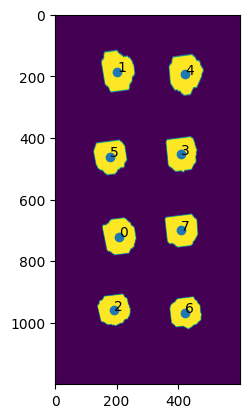

In [17]:
# 이미지 표시
plt.imshow(dab_homo)
plt.scatter(cluster_dab[:,0],cluster_dab[:,1]) 

# 점 플롯
plot_points_with_labels(cluster_dab)

plt.show()

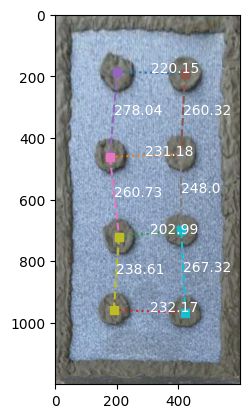

In [18]:
draw_dab_distances(cluster_dab)
img_homo = homography(img, intersection_points, width = 600, height = 1200)
img_homo = cv2.cvtColor(img_homo, cv2.COLOR_BGR2RGB)
plt.imshow(img_homo)


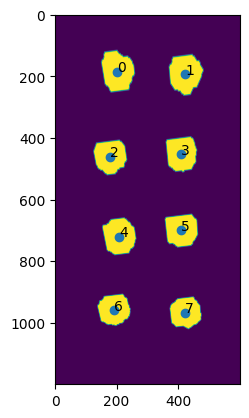

In [20]:
cluster_dab = coord_sort_z(cluster_dab)
plt.imshow(dab_homo)
plt.scatter(cluster_dab[:,0],cluster_dab[:,1]) 

# 점 플롯
plot_points_with_labels(cluster_dab)

600
[191 958]


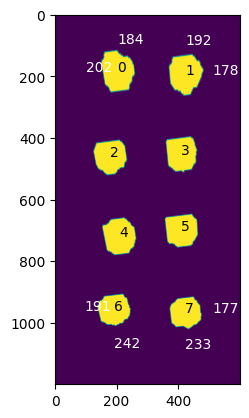

In [54]:
plot_points_with_labels(cluster_dab)

width = dab_homo.shape[1]
height = dab_homo.shape[0]

plt.text(cluster_dab[0][0],cluster_dab[0][1]/2, cluster_dab[0][1], color = 'white') # x축으로 부터의 거리를 text
plt.text(cluster_dab[0][0]/2,cluster_dab[0][1], cluster_dab[0][0], color = 'white') # y축으로 부터의 거리를 text

plt.text(cluster_dab[1][0],cluster_dab[1][1]/2, cluster_dab[1][1], color = 'white') # x축으로 부터의 거리를 text
plt.text((width + cluster_dab[1][0])/2,cluster_dab[1][1], width - cluster_dab[1][0], color = 'white') # y축으로 부터의 거리를 text

plt.text(cluster_dab[6][0], (height + cluster_dab[6][1])/2, height - cluster_dab[6][1], color = 'white') # width로 부터의 거리를 text
plt.text(cluster_dab[6][0]/2,cluster_dab[6][1], cluster_dab[6][0], color = 'white') # y축으로 부터의 거리를 text -> x 좌표

plt.text(cluster_dab[7][0], (height + cluster_dab[7][1])/2, height - cluster_dab[7][1], color = 'white') # width로 부터의 거리를 text
plt.text((width + cluster_dab[7][0])/2,cluster_dab[7][1], width - cluster_dab[7][0], color = 'white') # y축으로 부터의 거리를 text -> x 좌표

plt.imshow(dab_homo)
print(width)
print(cluster_dab[6])

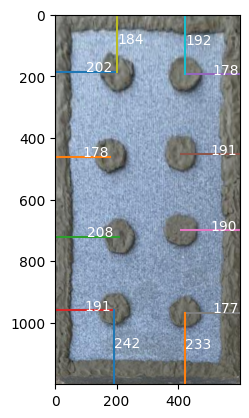

In [86]:
for k in range(0, len(cluster_dab),2):
    plt.plot((0, cluster_dab[k][0]),(cluster_dab[k][1], cluster_dab[k][1]))
    plt.text(cluster_dab[k][0]/2, cluster_dab[k][1], cluster_dab[k][0], color = 'white') # y축으로 부터의 거리를 text
for k in range(1, len(cluster_dab), 2):
    plt.plot((cluster_dab[k][0], width), (cluster_dab[k][1], cluster_dab[k][1]))
    plt.text((width + cluster_dab[k][0])/2, cluster_dab[k][1], width - cluster_dab[k][0], color = 'white') # y축으로 부터의 거리를 text
for k in range(2):
    plt.text(cluster_dab[k][0], cluster_dab[k][1]/2, cluster_dab[k][1], color = 'white') # x축으로 부터의 거리를 text
    plt.plot((cluster_dab[k][0], cluster_dab[k][0]), (0,cluster_dab[k][1]))
for k in range(6, len(cluster_dab,)):
    plt.text(cluster_dab[k][0], (height + cluster_dab[k][1])/2, height - cluster_dab[k][1], color = 'white') # width로 부터의 거리를 text    
    plt.plot((cluster_dab[k][0], cluster_dab[k][0]), (cluster_dab[k][1], height))
plt.imshow(img_homo)